In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## AutoEncoder

In [3]:
ae_train_data_path = "./../../data/external/fashion_mnist/fashion_mnist_train.csv"
ae_test_data_path = "./../../data/external/fashion_mnist/fashion_mnist_test.csv"

ae_train_data = pd.read_csv(ae_train_data_path)
ae_test_data = pd.read_csv(ae_test_data_path)

ae_val_data = ae_train_data.iloc[len(ae_train_data) - len(ae_test_data):]
ae_train_data = ae_train_data.iloc[:len(ae_train_data) - len(ae_test_data)]

ae_train_x = ae_train_data.drop('label', axis=1).values
ae_train_y = ae_train_data['label'].values

ae_val_x = ae_val_data.drop('label', axis=1).values
ae_val_y = ae_val_data['label'].values

ae_test_x = ae_test_data.drop('label', axis=1).values
ae_test_y = ae_test_data['label'].values

ae_train_x = ae_train_x/255.0
ae_val_x = ae_val_x/255.0
ae_test_x = ae_test_x/255.0

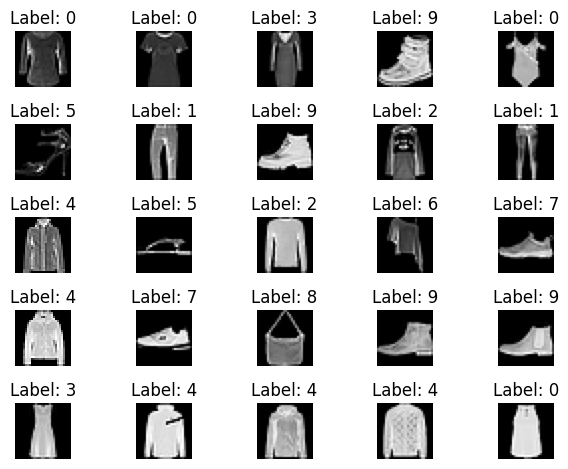

In [4]:
ae_train_data_sample = ae_train_data.sample(25)

ae_images = ae_train_data_sample.drop('label', axis=1).values
ae_labels = ae_train_data_sample['label'].values
ae_labels = ae_labels

ae_images = ae_images.reshape(-1, 28, 28)

ae_images = [Image.fromarray((image).astype(np.uint8)) for image in ae_images]

fig, axes = plt.subplots(5, 5)

for i, ax in enumerate(axes.flat):
    ax.imshow(ae_images[i], cmap='gray')
    ax.set_title(f"Label: {ae_labels[i]}")
    ax.axis('off')

plt.tight_layout()

In [5]:
class CnnAutoencoder(nn.Module):
    def __init__(self):
        super(CnnAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def loss(self, y_pred, y_true):
        return F.mse_loss(y_pred, y_true)

    def evaluate(self, data_loader, device):
        self.eval()
        total_loss = 0
        with torch.no_grad():
            for x, _ in data_loader:
                x = x.to(device)
                y_pred = self.forward(x)
                loss = self.loss(y_pred, x)
                total_loss += loss.item()
        return total_loss / len(data_loader)
    
    def train_model(self, optimizer, train_loader, val_loader, num_epochs=10, device='cpu'):
        self.to(device)
        for epoch in range(num_epochs):
            self.train()
            train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}")
            
            for i, (x, _) in train_progress:
                x = x.to(device)
                optimizer.zero_grad()
                y_pred = self(x)
                loss = self.loss(y_pred, x)
                loss.backward()
                optimizer.step()
                train_progress.set_postfix({"Loss": f"{loss.item():.4f}"})
            
            val_loss = self.evaluate(val_loader, device)
            print(f"Epoch {epoch + 1}, Validation Loss: {val_loss:.6f}")


In [6]:
class MultiMNISTDataset_ae(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = torch.tensor(image.reshape(-1, 28, 28), dtype=torch.float32)
        return image, label

In [7]:
train_data_ae = MultiMNISTDataset_ae(ae_train_x, ae_train_y)
val_data_ae = MultiMNISTDataset_ae(ae_val_x, ae_val_y)
test_data_ae = MultiMNISTDataset_ae(ae_test_x, ae_test_y)

train_loader_ae = DataLoader(train_data_ae, batch_size=32, shuffle=True)
val_loader_ae = DataLoader(val_data_ae, batch_size=32, shuffle=False)
test_loader_ae = DataLoader(test_data_ae, batch_size=32, shuffle=False)

In [8]:
autoencoder = CnnAutoencoder().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
autoencoder.train_model(optimizer, train_loader_ae, val_loader_ae, num_epochs=10, device=device)

Epoch 1/10: 100%|██████████| 1563/1563 [00:10<00:00, 151.09it/s, Loss=0.0115]


Epoch 1, Validation Loss: 0.011938


Epoch 2/10: 100%|██████████| 1563/1563 [00:13<00:00, 114.66it/s, Loss=0.0082]


Epoch 2, Validation Loss: 0.009048


Epoch 3/10: 100%|██████████| 1563/1563 [00:12<00:00, 121.82it/s, Loss=0.0072]


Epoch 3, Validation Loss: 0.007877


Epoch 4/10: 100%|██████████| 1563/1563 [00:10<00:00, 142.57it/s, Loss=0.0063]


Epoch 4, Validation Loss: 0.007208


Epoch 5/10: 100%|██████████| 1563/1563 [00:11<00:00, 132.23it/s, Loss=0.0069]


Epoch 5, Validation Loss: 0.006853


Epoch 6/10: 100%|██████████| 1563/1563 [00:13<00:00, 117.46it/s, Loss=0.0046]


Epoch 6, Validation Loss: 0.006554


Epoch 7/10: 100%|██████████| 1563/1563 [00:09<00:00, 160.75it/s, Loss=0.0063]


Epoch 7, Validation Loss: 0.006385


Epoch 8/10: 100%|██████████| 1563/1563 [00:09<00:00, 164.47it/s, Loss=0.0081]


Epoch 8, Validation Loss: 0.006232


Epoch 9/10: 100%|██████████| 1563/1563 [00:09<00:00, 161.05it/s, Loss=0.0063]


Epoch 9, Validation Loss: 0.006100


Epoch 10/10: 100%|██████████| 1563/1563 [00:09<00:00, 163.35it/s, Loss=0.0059]


Epoch 10, Validation Loss: 0.006028


In [9]:
def plot_reconstruction(model, data_loader):
    model.eval()
    with torch.no_grad():
        for x, _ in data_loader:
            x = x.to(device)
            y_pred = model(x)
            break

    x = x.cpu().numpy()
    y_pred = y_pred.cpu().numpy()

    fig, axes = plt.subplots(2, 10, figsize=(15, 5))
    fig.subplots_adjust(hspace=0.4)
    for i in range(10):
        axes[0, i].imshow(x[i].reshape(28, 28), cmap='gray')
        axes[1, i].imshow(y_pred[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].axis('off')
        axes[0, i].set_title("Original")
        axes[1, i].set_title("Reconstructed")

    plt.tight_layout()
    plt.show()


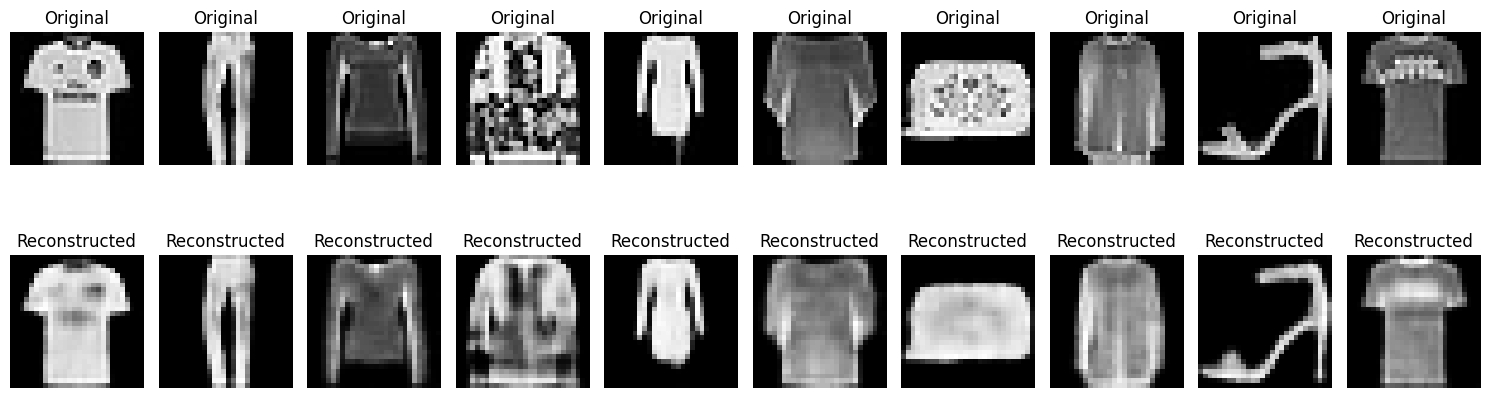

In [10]:
plot_reconstruction(autoencoder, test_loader_ae)

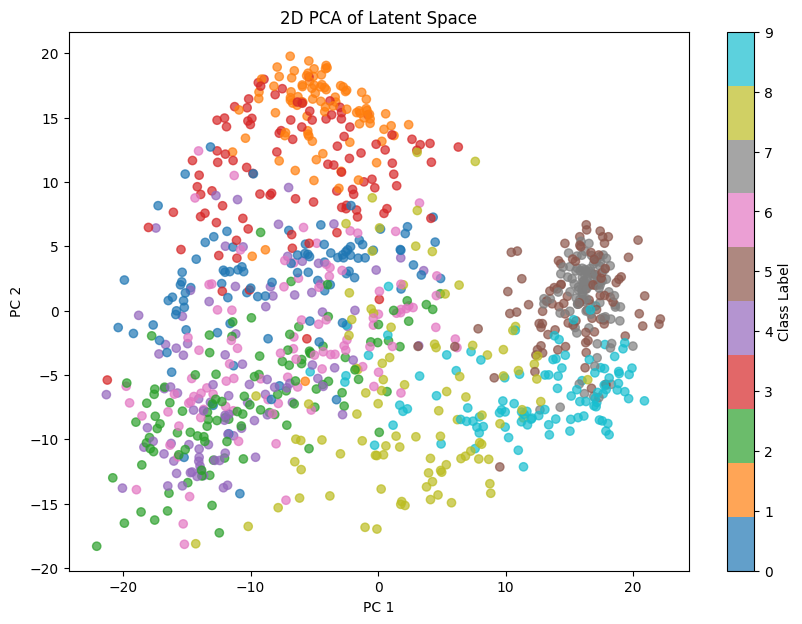

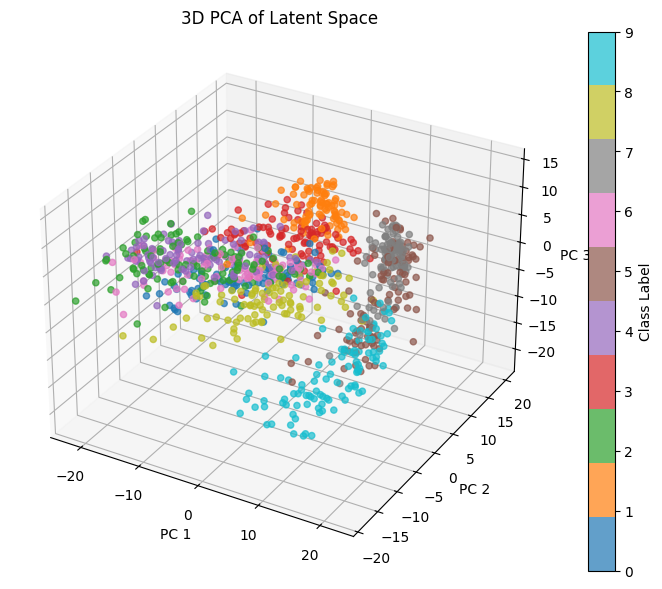

In [11]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

def plot_latent_space(model, data_loader, num_samples=1000):
    model.eval()
    latent_representations = []
    labels = []
    
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            encoded = model.encode(x)
            latent_representations.append(encoded.view(encoded.size(0), -1).cpu().numpy())
            labels.extend(y.cpu().numpy())
            if len(labels) >= num_samples:
                break
    
    latent_representations = np.concatenate(latent_representations)[:num_samples]
    labels = np.array(labels)[:num_samples]
    
    pca_2d = PCA(n_components=2)
    latent_2d = pca_2d.fit_transform(latent_representations)
    
    pca_3d = PCA(n_components=3)
    latent_3d = pca_3d.fit_transform(latent_representations)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, label='Class Label')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.title("2D PCA of Latent Space")
    plt.show()

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(latent_3d[:, 0], latent_3d[:, 1], latent_3d[:, 2], c=labels, cmap='tab10', alpha=0.7)
    fig.colorbar(scatter, ax=ax, label='Class Label')
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")
    ax.set_zlabel("PC 3")
    plt.title("3D PCA of Latent Space")
    plt.show()

plot_latent_space(autoencoder, test_loader_ae)


#### Hyperparameter Tuning

In [58]:
class CnnAutoencoder_tuning(nn.Module):
    def __init__(self, input_channels=1, filter_sizes=[16, 32, 64], kernel_size=5):
        super(CnnAutoencoder_tuning, self).__init__()

        if (len(filter_sizes)==2):
            self.encoder = nn.Sequential(
                nn.Conv2d(input_channels, filter_sizes[0], kernel_size, stride=2, padding=2),
                nn.ReLU(),
                nn.Conv2d(filter_sizes[0], filter_sizes[1], kernel_size, stride=2, padding=2)
            )

            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(filter_sizes[1], filter_sizes[0], kernel_size, stride=2, padding=2, output_padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(filter_sizes[0], input_channels, kernel_size, stride=2, padding=2, output_padding=1),
                nn.Sigmoid()
            )

        elif (len(filter_sizes)==3):
            self.encoder = nn.Sequential(
                nn.Conv2d(input_channels, filter_sizes[0], kernel_size, stride=2, padding=kernel_size//2),
                nn.ReLU(),
                nn.Conv2d(filter_sizes[0], filter_sizes[1], kernel_size, stride=2, padding=kernel_size//2),
                nn.ReLU(),
                nn.Conv2d(filter_sizes[1], filter_sizes[2], kernel_size, stride=1, padding=0)
            )
            
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(filter_sizes[2], filter_sizes[1], kernel_size, stride=1, padding=0),
                nn.ReLU(),
                nn.ConvTranspose2d(filter_sizes[1], filter_sizes[0], kernel_size, stride=2, padding=kernel_size//2, output_padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(filter_sizes[0], input_channels, kernel_size, stride=2, padding=kernel_size//2, output_padding=1),
                nn.Sigmoid()
            )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def loss(self, y_pred, y_true):
        return F.mse_loss(y_pred, y_true)

    def evaluate(self, data_loader, device):
        self.eval()
        total_loss = 0
        with torch.no_grad():
            for x, _ in data_loader:
                x = x.to(device)
                y_pred = self.forward(x)
                loss = self.loss(y_pred, x)
                total_loss += loss.item()
        return total_loss / len(data_loader)
    
    def train_model(self, optimizer, train_loader, val_loader, num_epochs=10, device='cpu'):
        self.to(device)
        train_losses, val_losses = [], []
        
        for epoch in range(num_epochs):
            self.train()
            total_train_loss = 0
            for x, _ in train_loader:
                x = x.to(device)
                optimizer.zero_grad()
                y_pred = self(x)
                loss = self.loss(y_pred, x)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()
            
            avg_train_loss = total_train_loss / len(train_loader)
            val_loss = self.evaluate(val_loader, device)
            
            train_losses.append(avg_train_loss)
            val_losses.append(val_loss)
            
            # print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        
        return train_losses, val_losses


In [26]:
from itertools import product

configs = {
    'learning_rate': [0.001, 0.0005],
    'kernel_size': [3, 5],
    'filter_sizes': [[16, 32, 64]],
    'optimizer': [torch.optim.Adam, torch.optim.SGD]
}

best_val_loss = float('inf')
best_config = None

for lr, ks, fltrs, opt in product(*configs.values()):
    print(f"Training with Learning Rate: {lr}, Kernel Size: {ks}, Filter Sizes: {fltrs}, Optimizer: {opt.__name__}")
    model = CnnAutoencoder_tuning(kernel_size=ks, filter_sizes=fltrs).to(device)
    optimizer = opt(model.parameters(), lr=lr)
    
    train_losses, val_losses = model.train_model(optimizer, train_loader_ae, val_loader_ae, num_epochs=20, device=device)
    final_val_loss = val_losses[-1]
    print(f"Final Validation Loss: {val_losses[-1]:.6f}")

    if final_val_loss < best_val_loss:
        best_val_loss = final_val_loss
        best_config = {'learning_rate': lr, 'kernel_size': ks, 'filters': fltrs, 'optimizer': opt.__name__}

print("Best Configuration:", best_config)
print("Validation Loss:", best_val_loss)


Training with Learning Rate: 0.001, Kernel Size: 3, Filter Sizes: [16, 32, 64], Optimizer: Adam
Final Validation Loss: 0.000932
Training with Learning Rate: 0.001, Kernel Size: 3, Filter Sizes: [16, 32, 64], Optimizer: SGD
Final Validation Loss: 0.109172
Training with Learning Rate: 0.001, Kernel Size: 5, Filter Sizes: [16, 32, 64], Optimizer: Adam
Final Validation Loss: 0.001279
Training with Learning Rate: 0.001, Kernel Size: 5, Filter Sizes: [16, 32, 64], Optimizer: SGD
Final Validation Loss: 0.125549
Training with Learning Rate: 0.0005, Kernel Size: 3, Filter Sizes: [16, 32, 64], Optimizer: Adam
Final Validation Loss: 0.001027
Training with Learning Rate: 0.0005, Kernel Size: 3, Filter Sizes: [16, 32, 64], Optimizer: SGD
Final Validation Loss: 0.126886
Training with Learning Rate: 0.0005, Kernel Size: 5, Filter Sizes: [16, 32, 64], Optimizer: Adam
Final Validation Loss: 0.001772
Training with Learning Rate: 0.0005, Kernel Size: 5, Filter Sizes: [16, 32, 64], Optimizer: SGD
Final Va

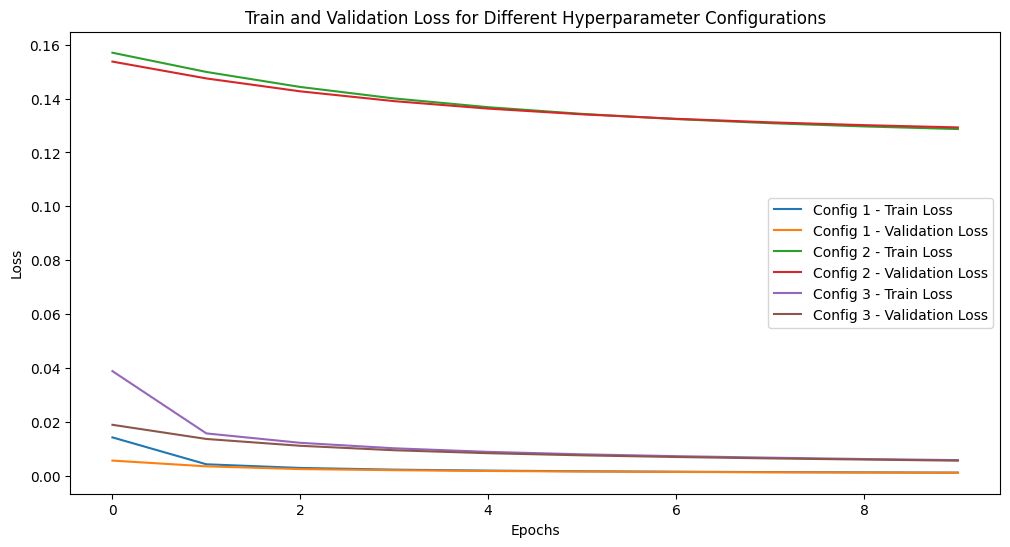

In [27]:
def train_and_plot(model, optimizer, config_name):
    train_losses, val_losses = model.train_model(optimizer, train_loader_ae, val_loader_ae, num_epochs=10, device=device)
    plt.plot(train_losses, label=f"{config_name} - Train Loss")
    plt.plot(val_losses, label=f"{config_name} - Validation Loss")

configs_to_plot = [
    {'learning_rate': 0.001, 'kernel_size': 3, 'filters': [16, 32, 64], 'optimizer': torch.optim.Adam},
    {'learning_rate': 0.0005, 'kernel_size': 3, 'filters': [32, 64, 128], 'optimizer': torch.optim.SGD},
    {'learning_rate': 0.0001, 'kernel_size': 5, 'filters': [16, 32, 64], 'optimizer': torch.optim.Adam}
]

plt.figure(figsize=(12, 6))
for i, config in enumerate(configs_to_plot):
    model = CnnAutoencoder_tuning(kernel_size=config['kernel_size'], filter_sizes=config['filters']).to(device)
    optimizer = config['optimizer'](model.parameters(), lr=config['learning_rate'])
    train_and_plot(model, optimizer, f"Config {i + 1}")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Train and Validation Loss for Different Hyperparameter Configurations")
plt.show()


Training with Depth: 2
Training with Depth: 3


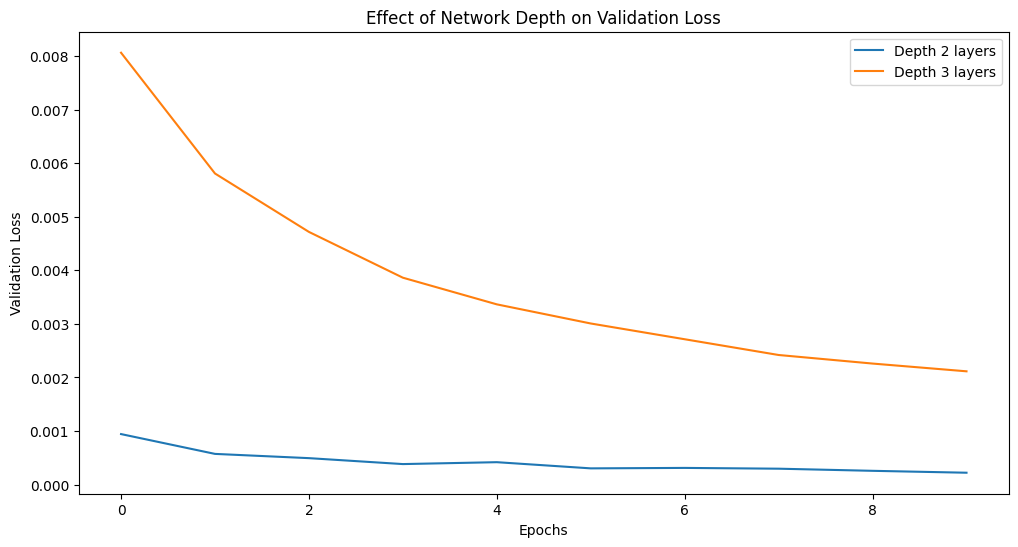

In [59]:
depth_configs = [
    [32, 64],
    [16, 32, 64],
    # [16, 32, 64, 128] 
]

plt.figure(figsize=(12, 6))

for depth in depth_configs:
    model = CnnAutoencoder_tuning(filter_sizes=depth).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    print(f"Training with Depth: {len(depth)}")
    train_losses, val_losses = model.train_model(optimizer, train_loader_ae, val_loader_ae, num_epochs=10, device=device)
    plt.plot(val_losses, label=f"Depth {len(depth)} layers")

plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.legend()
plt.title("Effect of Network Depth on Validation Loss")
plt.show()


### MLP AutoEncoder

In [12]:
import sys
sys.path.append('./../../')

In [13]:
from models.autoencoder.autoencoder import AutoEncoder

input_dim = ae_train_x.shape[1]
latent_dim = 64
neurons_per_layer = [128] 
mlp_autoencoder = AutoEncoder(input_dim=input_dim, latent_dim=latent_dim, neurons_per_layer=neurons_per_layer, learning_rate=0.001, n_epochs=50, batch_size=32)

mlp_autoencoder.fit(ae_train_x)

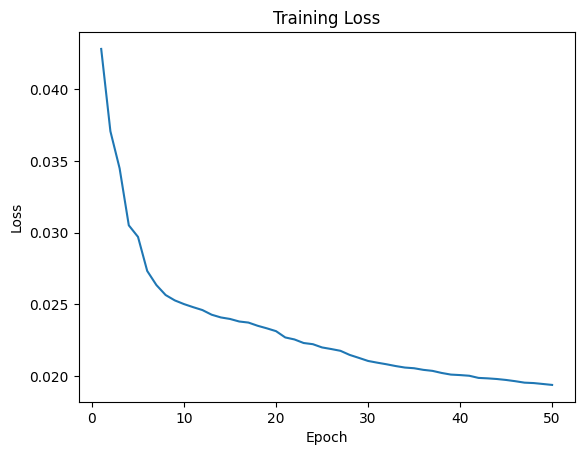

In [14]:
epochs = range(1, mlp_autoencoder.autoencoder.n_epochs + 1)
plt.plot(epochs, mlp_autoencoder.autoencoder.loss_list, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

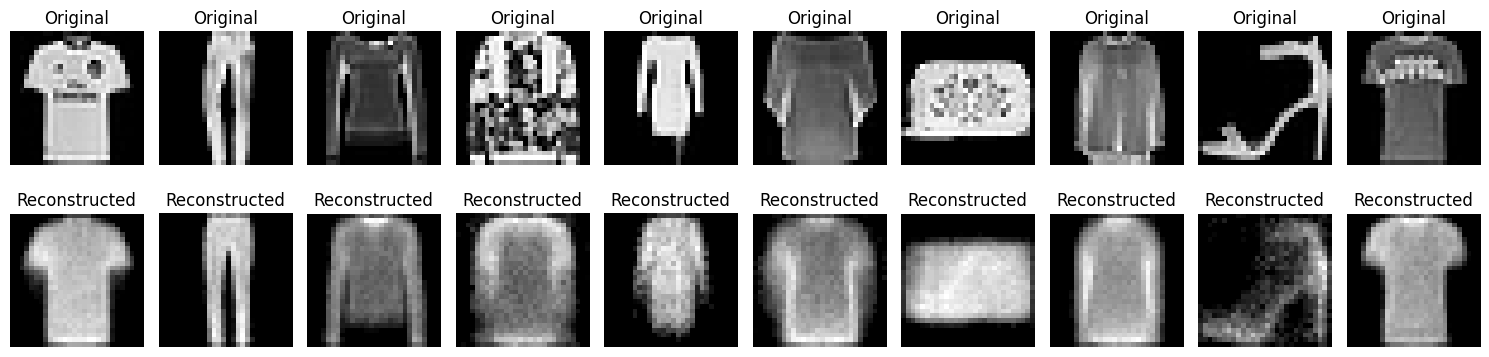

In [15]:
test_reconstructions = mlp_autoencoder.reconstruct(ae_test_x[:10])

original_images = ae_test_x[:10].reshape(-1, 28, 28)
reconstructed_images = test_reconstructions.reshape(-1, 28, 28)

fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for i in range(10):
    axes[0, i].imshow(original_images[i], cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title("Original")

    axes[1, i].imshow(reconstructed_images[i], cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title("Reconstructed")

plt.tight_layout()
plt.show()


In [16]:
from models.pca.pca import PCA

class PCA_autoencoder:
    def __init__(self, latent_dim):
        self.latent_dim = latent_dim
        self.pca = PCA(latent_dim)
    
    def fit(self, x):
        self.pca.fit(x)

    def encode(self, x):
        return self.pca.transform(x)

    def forward(self, x):
        x_encoded = self.encode(x)
        return np.dot(x_encoded, self.pca.eig_vectors[:, :self.latent_dim].T) + self.pca.means

In [17]:
def estimate_optimal_components(X_train, X_val, max_components=100):
    mse_errors = []
    component_range = range(1, max_components + 1)

    for n_components in component_range:
        pca_autoencoder = PCA_autoencoder(latent_dim=n_components)
        pca_autoencoder.fit(X_train)
        X_val_reconstructed = pca_autoencoder.forward(X_val)
        mse = np.mean((X_val - X_val_reconstructed) ** 2)
        mse_errors.append(mse)

    plt.plot(component_range, mse_errors)
    plt.xlabel("Number of Components")
    plt.ylabel("Reconstruction Error (MSE)")
    plt.title("Elbow Plot of Reconstruction Error vs Number of Components")
    plt.show()

    k_optimal = component_range[np.argmin(np.gradient(np.gradient(mse_errors)))]
    print(f"Optimal number of components (koptimal): {k_optimal}")

    return k_optimal, mse_errors

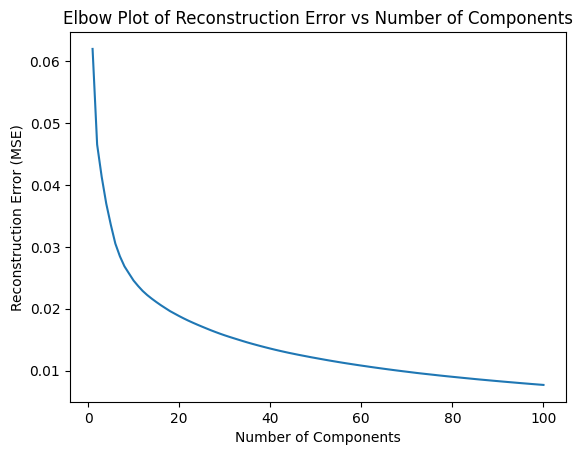

Optimal number of components (koptimal): 75


In [18]:
k_optimal, mse_errors = estimate_optimal_components(ae_train_x, ae_val_x, max_components=100)

In [19]:
def visualize_reconstructions(pca_autoencoder, X_test, num_images=10):
    X_reconstructed = pca_autoencoder.forward(X_test)

    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title("Original")

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(X_reconstructed[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title("Reconstructed")

    plt.tight_layout()
    plt.show()

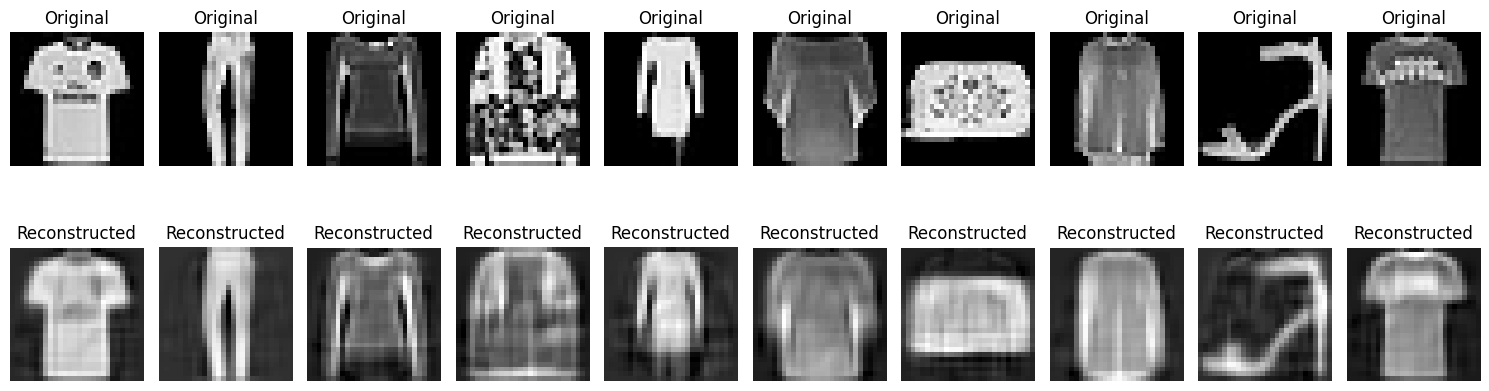

In [20]:
pca_autoencoder = PCA_autoencoder(latent_dim=k_optimal)
pca_autoencoder.fit(ae_train_x)

visualize_reconstructions(pca_autoencoder, ae_test_x[:10])

### KNN Classification

In [21]:
class CnnAutoencoder_knn(nn.Module):
    def __init__(self):
        super(CnnAutoencoder_knn, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, k_optimal, 7)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(k_optimal, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def loss(self, y_pred, y_true):
        return F.mse_loss(y_pred, y_true)

    def evaluate(self, data_loader, device):
        self.eval()
        total_loss = 0
        with torch.no_grad():
            for x, _ in data_loader:
                x = x.to(device)
                y_pred = self.forward(x)
                loss = self.loss(y_pred, x)
                total_loss += loss.item()
        return total_loss / len(data_loader)
    
    def train_model(self, optimizer, train_loader, val_loader, num_epochs=10, device='cpu'):
        self.to(device)
        for epoch in range(num_epochs):
            self.train()
            train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}")
            
            for i, (x, _) in train_progress:
                x = x.to(device)
                optimizer.zero_grad()
                y_pred = self(x)
                loss = self.loss(y_pred, x)
                loss.backward()
                optimizer.step()
                train_progress.set_postfix({"Loss": f"{loss.item():.4f}"})
            
            val_loss = self.evaluate(val_loader, device)
            print(f"Epoch {epoch + 1}, Validation Loss: {val_loss:.6f}")


In [22]:
autoencoder_knn = CnnAutoencoder_knn().to(device)
optimizer = torch.optim.Adam(autoencoder_knn.parameters(), lr=0.001)
autoencoder_knn.train_model(optimizer, train_loader_ae, val_loader_ae, num_epochs=10, device=device)

Epoch 1/10: 100%|██████████| 1563/1563 [00:11<00:00, 139.64it/s, Loss=0.0108]


Epoch 1, Validation Loss: 0.011644


Epoch 2/10: 100%|██████████| 1563/1563 [00:10<00:00, 150.72it/s, Loss=0.0069]


Epoch 2, Validation Loss: 0.008676


Epoch 3/10: 100%|██████████| 1563/1563 [00:10<00:00, 151.40it/s, Loss=0.0069]


Epoch 3, Validation Loss: 0.007429


Epoch 4/10: 100%|██████████| 1563/1563 [00:10<00:00, 150.86it/s, Loss=0.0071]


Epoch 4, Validation Loss: 0.006705


Epoch 5/10: 100%|██████████| 1563/1563 [00:10<00:00, 150.36it/s, Loss=0.0057]


Epoch 5, Validation Loss: 0.006374


Epoch 6/10: 100%|██████████| 1563/1563 [00:10<00:00, 151.64it/s, Loss=0.0077]


Epoch 6, Validation Loss: 0.006027


Epoch 7/10: 100%|██████████| 1563/1563 [00:10<00:00, 146.70it/s, Loss=0.0066]


Epoch 7, Validation Loss: 0.005898


Epoch 8/10: 100%|██████████| 1563/1563 [00:10<00:00, 150.17it/s, Loss=0.0050]


Epoch 8, Validation Loss: 0.005711


Epoch 9/10: 100%|██████████| 1563/1563 [00:10<00:00, 149.49it/s, Loss=0.0069]


Epoch 9, Validation Loss: 0.005743


Epoch 10/10: 100%|██████████| 1563/1563 [00:10<00:00, 149.72it/s, Loss=0.0060]


Epoch 10, Validation Loss: 0.005532


In [23]:
train_data_ae = MultiMNISTDataset_ae(ae_train_x, ae_train_y)
test_data_ae = MultiMNISTDataset_ae(ae_test_x, ae_test_y)

train_loader_ae = DataLoader(train_data_ae, batch_size=32, shuffle=False)
test_loader_ae = DataLoader(test_data_ae, batch_size=32, shuffle=False)

ae_train_x_encoded_cnn = []
ae_test_x_encoded_cnn = []

autoencoder_knn.eval()
with torch.no_grad():
    for x, _ in train_loader_ae:
        x = x.to(device)
        encoded = autoencoder_knn.encode(x)
        ae_train_x_encoded_cnn.append(encoded.view(encoded.size(0), -1).cpu().numpy())

    for x, _ in test_loader_ae:
        x = x.to(device)
        encoded = autoencoder_knn.encode(x)
        ae_test_x_encoded_cnn.append(encoded.view(encoded.size(0), -1).cpu().numpy())

ae_train_x_encoded_cnn = np.concatenate(ae_train_x_encoded_cnn)
ae_test_x_encoded_cnn = np.concatenate(ae_test_x_encoded_cnn)

In [24]:
input_dim = ae_train_x.shape[1]
latent_dim = k_optimal
neurons_per_layer = [128] 
mlp_autoencoder_knn = AutoEncoder(input_dim=input_dim, latent_dim=latent_dim, neurons_per_layer=neurons_per_layer, learning_rate=0.001, n_epochs=50, batch_size=32)

mlp_autoencoder_knn.fit(ae_train_x)

In [25]:
ae_train_x_encoded_mlp = mlp_autoencoder_knn.get_latent(ae_train_x)
ae_test_x_encoded_mlp = mlp_autoencoder_knn.get_latent(ae_test_x)

In [26]:
pca_autoencoder_knn = PCA_autoencoder(latent_dim=k_optimal)
pca_autoencoder_knn.fit(ae_train_x)

In [27]:
ae_train_x_encoded_pca = pca_autoencoder_knn.encode(ae_train_x)
ae_test_x_encoded_pca = pca_autoencoder_knn.encode(ae_test_x)

In [28]:
from models.knn.knn import KNN
from performance_measures.knn_score import Scores

In [29]:
knn_k = 5

In [30]:
knn_cnn = KNN(k=knn_k)
knn_cnn.fit(ae_train_x_encoded_cnn, ae_train_y)
ae_pred_cnn = knn_cnn.predict(ae_test_x_encoded_cnn, distance_metric='cosine')
scores_cnn = Scores(ae_test_y, ae_pred_cnn)
accuracy_cnn = scores_cnn.accuracy
print(f"Accuracy of KNN with CNN Autoencoder: {accuracy_cnn:.2f}")

Accuracy of KNN with CNN Autoencoder: 0.88


In [31]:
knn_mlp = KNN(k=knn_k)
knn_mlp.fit(ae_train_x_encoded_mlp, ae_train_y)
ae_pred_mlp = knn_mlp.predict(ae_test_x_encoded_mlp, distance_metric='cosine')
scores_mlp = Scores(ae_test_y, ae_pred_mlp)
accuracy_mlp = scores_mlp.accuracy
print(f"Accuracy of KNN with MLP Autoencoder: {accuracy_mlp:.2f}")

Accuracy of KNN with MLP Autoencoder: 0.83


In [32]:
knn_pca = KNN(k=knn_k)
knn_pca.fit(ae_train_x_encoded_pca, ae_train_y)
ae_pred_pca = knn_pca.predict(ae_test_x_encoded_pca, distance_metric='cosine')
scores_pca = Scores(ae_test_y, ae_pred_pca)
accuracy_pca = scores_pca.accuracy
print(f"Accuracy of KNN with PCA: {accuracy_pca:.2f}")

Accuracy of KNN with PCA: 0.86


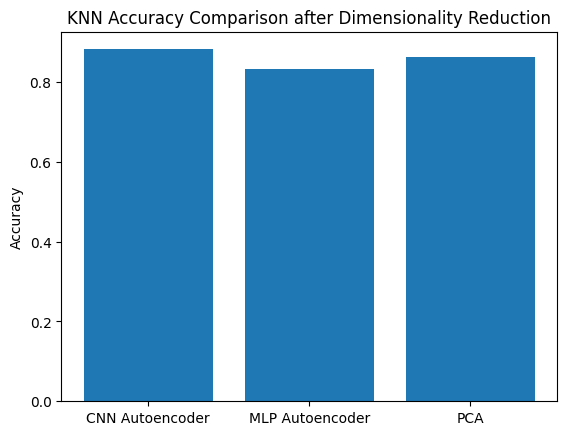

In [33]:
accuracies = [accuracy_cnn, accuracy_mlp, accuracy_pca]
labels = ['CNN Autoencoder', 'MLP Autoencoder', 'PCA']

plt.bar(labels, accuracies)
plt.ylabel('Accuracy')
plt.title('KNN Accuracy Comparison after Dimensionality Reduction')
plt.show()

In [34]:
confusion_matrix_cnn = scores_cnn.confusion_matrix
confusion_matrix_mlp = scores_mlp.confusion_matrix
confusion_matrix_pca = scores_pca.confusion_matrix

confusion_matrix_cnn = confusion_matrix_cnn.astype(np.int32)
confusion_matrix_mlp = confusion_matrix_mlp.astype(np.int32)
confusion_matrix_pca = confusion_matrix_pca.astype(np.int32)

In [35]:
import seaborn as sns

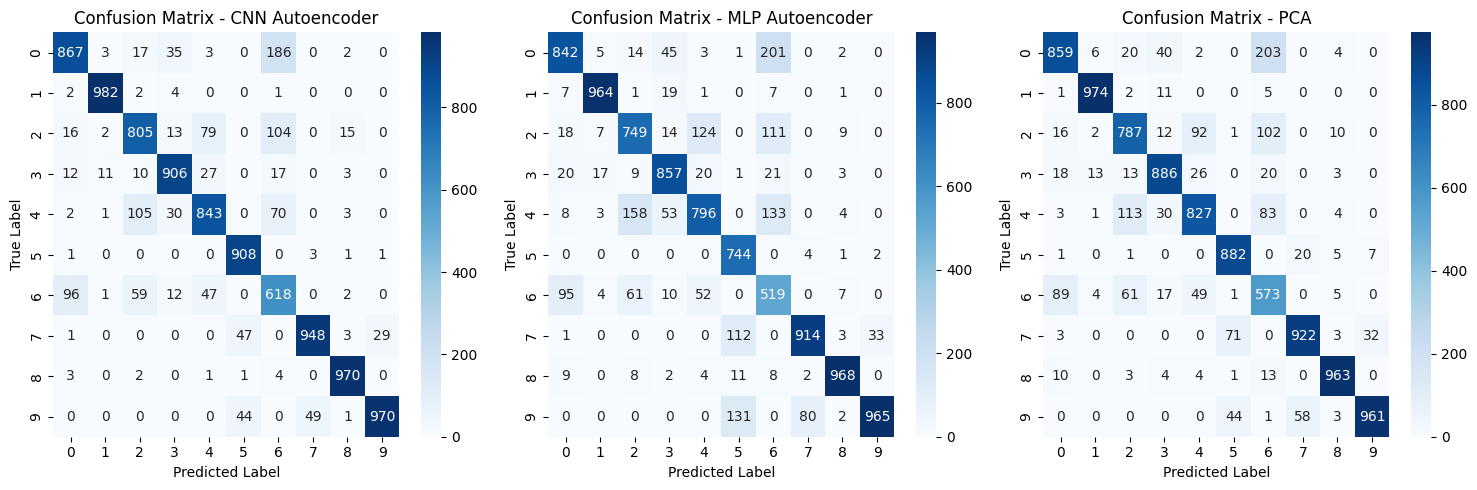

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(confusion_matrix_cnn, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - CNN Autoencoder')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

sns.heatmap(confusion_matrix_mlp, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix - MLP Autoencoder')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')


sns.heatmap(confusion_matrix_pca, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_title('Confusion Matrix - PCA')
axes[2].set_xlabel('Predicted Label')
axes[2].set_ylabel('True Label')

plt.tight_layout()
plt.show()